In [1]:
import sys
import pandas as pd
sys.path.insert(0, "../")

from michael import janet

Hi there. Welcome to the good place.


In [2]:
uni = pd.read_csv("/Users/oliver hall/Research/unicorn/data/unicorn.csv", index_col=0)

Index 258 is a good tester. Clear rotational signal, ambiguous peak mode.

In [13]:
j = janet.boot(uni, index=976)

Making folder /Users/oliver hall/Research/unicorn/data/3308452929183913216/...
Found star in Sector(s) 5


/Users/Anaconda/anaconda3/lib/python3.8/site-packages/eleanor-2.0.2-py3.8.egg/eleanor/ffi.py:40: UserWarning: couldn't find pointing model
  warnings.warn("couldn't find pointing model")


/Users/Anaconda/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Anaconda/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/Anaconda/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


No postcard object will be created for this target.
### Running Simple Astropy Lomb-Scargle on Sector all on star 3308452929183913216 ###
### Completed Simple Astropy Lomb-Scargle for Sector all on star 3308452929183913216 ###
### Saved results ###
### Running Wavelet Estimation on star 3308452929183913216 ###



### Completed Wavelet Estimation on star 3308452929183913216 ###
### Saved results ###


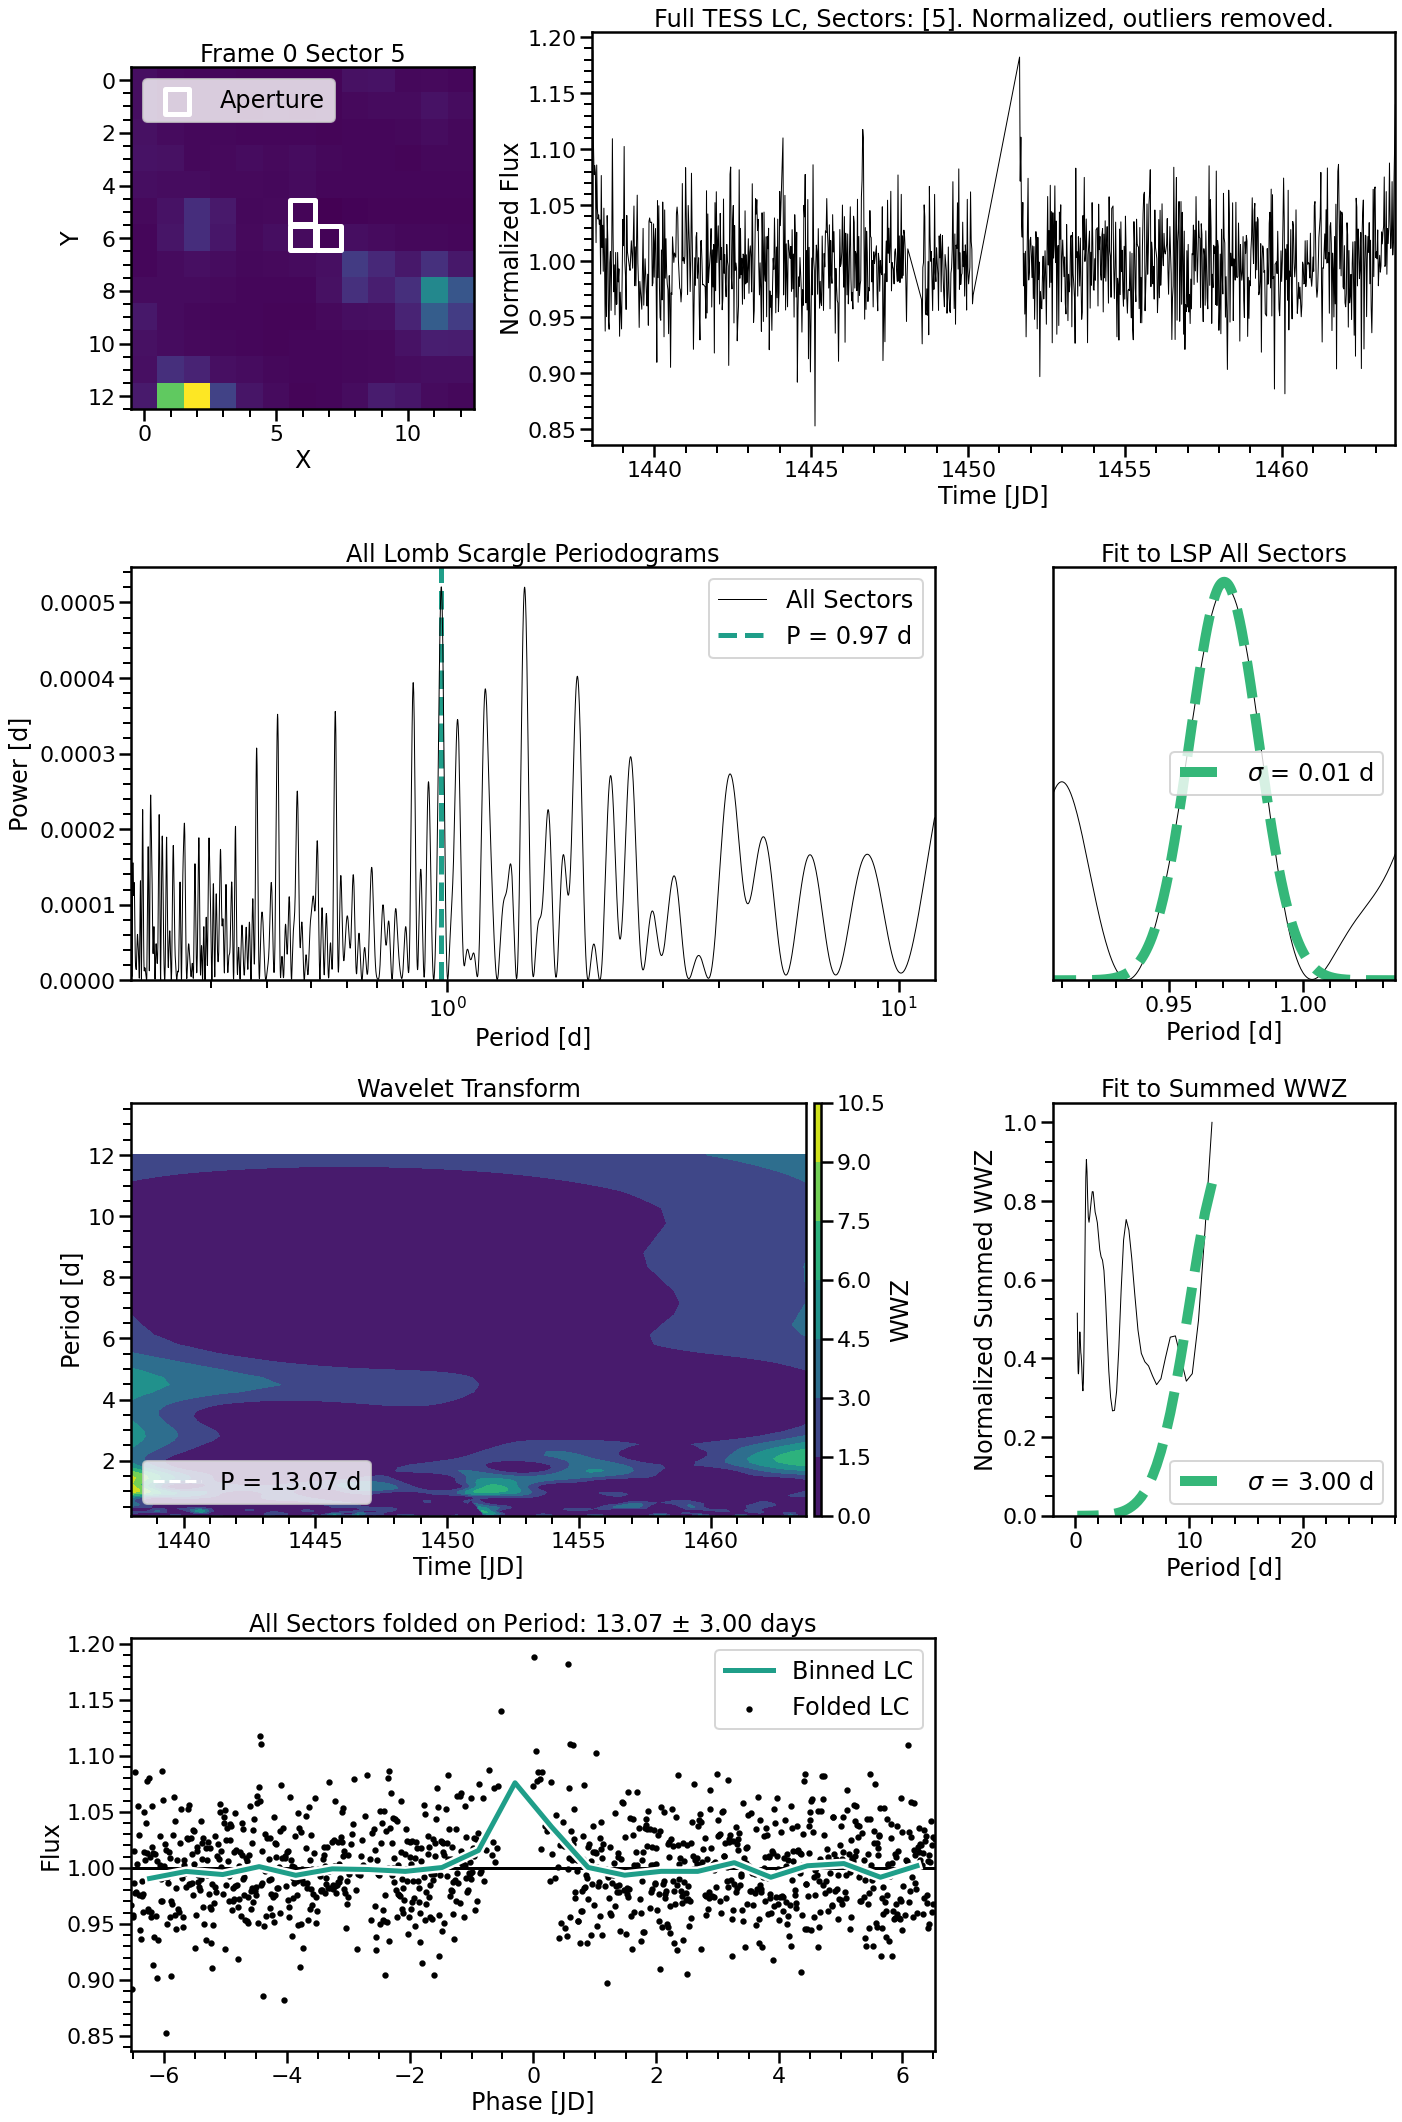

In [14]:
j.run()

In [17]:
j.get_rotation(period_range = (0.1, 5))

### Running Simple Astropy Lomb-Scargle on Sector all on star 3308452929183913216 ###
### Completed Simple Astropy Lomb-Scargle for Sector all on star 3308452929183913216 ###
### Saved results ###
### Running Wavelet Estimation on star 3308452929183913216 ###



### Completed Wavelet Estimation on star 3308452929183913216 ###
### Saved results ###


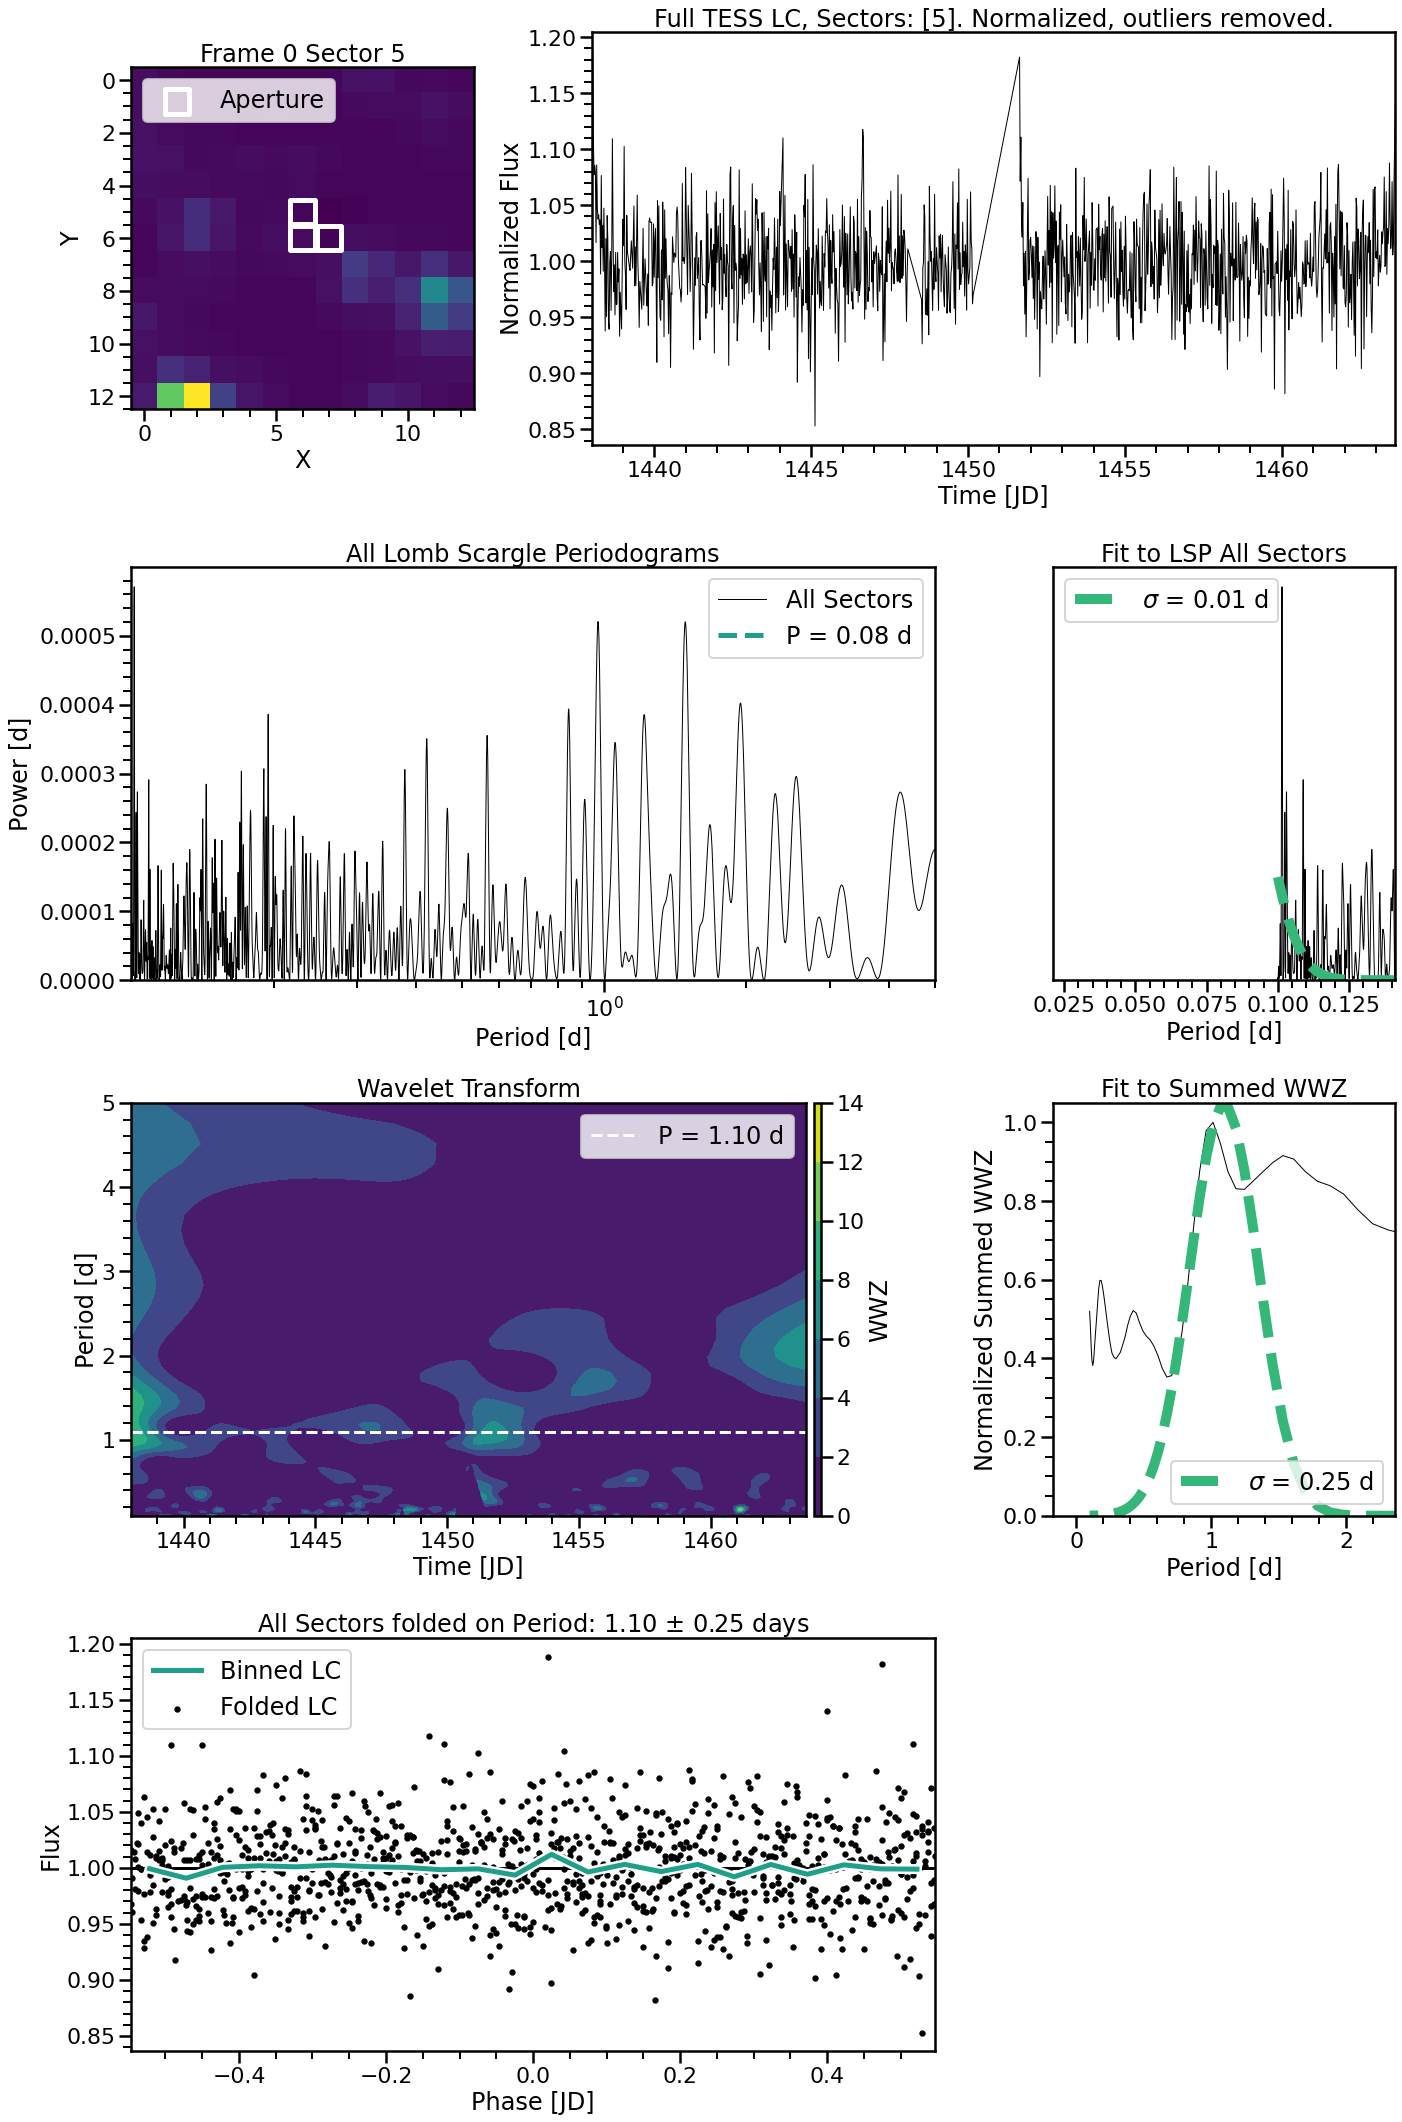

In [18]:
j.validate_rotation()
j.view()

In [15]:
j.results

,SLS,e_SLS,f_SLS,SW,e_SW,s_SLS,overall,e_overall,f_overall
all,0.970598,0.012801,3.0,13.066903,3.0,NaN,NaN,NaN,NaN
best,0.970598,0.012801,NaN,13.066903,3.0,all,13.066903,3.0,34.0


### Test & training runs

In [4]:
j

Hi there! I'm Janet 🌵
I don't have any data or results in storage right now. Try running `janet.prepare_data()` to get started! ✨

In [5]:
j.prepare_data()

Already have data loaded for Gaia ID 3308656888590487296.
If you want to check for new data, run `janet.Update()`.
No postcard object will be created for this target.


In [6]:
period_range = (5, 8)
# j.get_rotation(period_range = period_range)
j.get_rotation()

### Running Simple Astropy Lomb-Scargle on Sector all on star 3308656888590487296 ###
### Completed Simple Astropy Lomb-Scargle for Sector all on star 3308656888590487296 ###
### Saved results ###
### Running Wavelet Estimation on star 3308656888590487296 ###


/Users/Anaconda/anaconda3/lib/python3.8/site-packages/jazzhands/wavelets.py:488: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm



### Completed Wavelet Estimation on star 3308656888590487296 ###
### Saved results ###


In [7]:
j.validate_rotation()

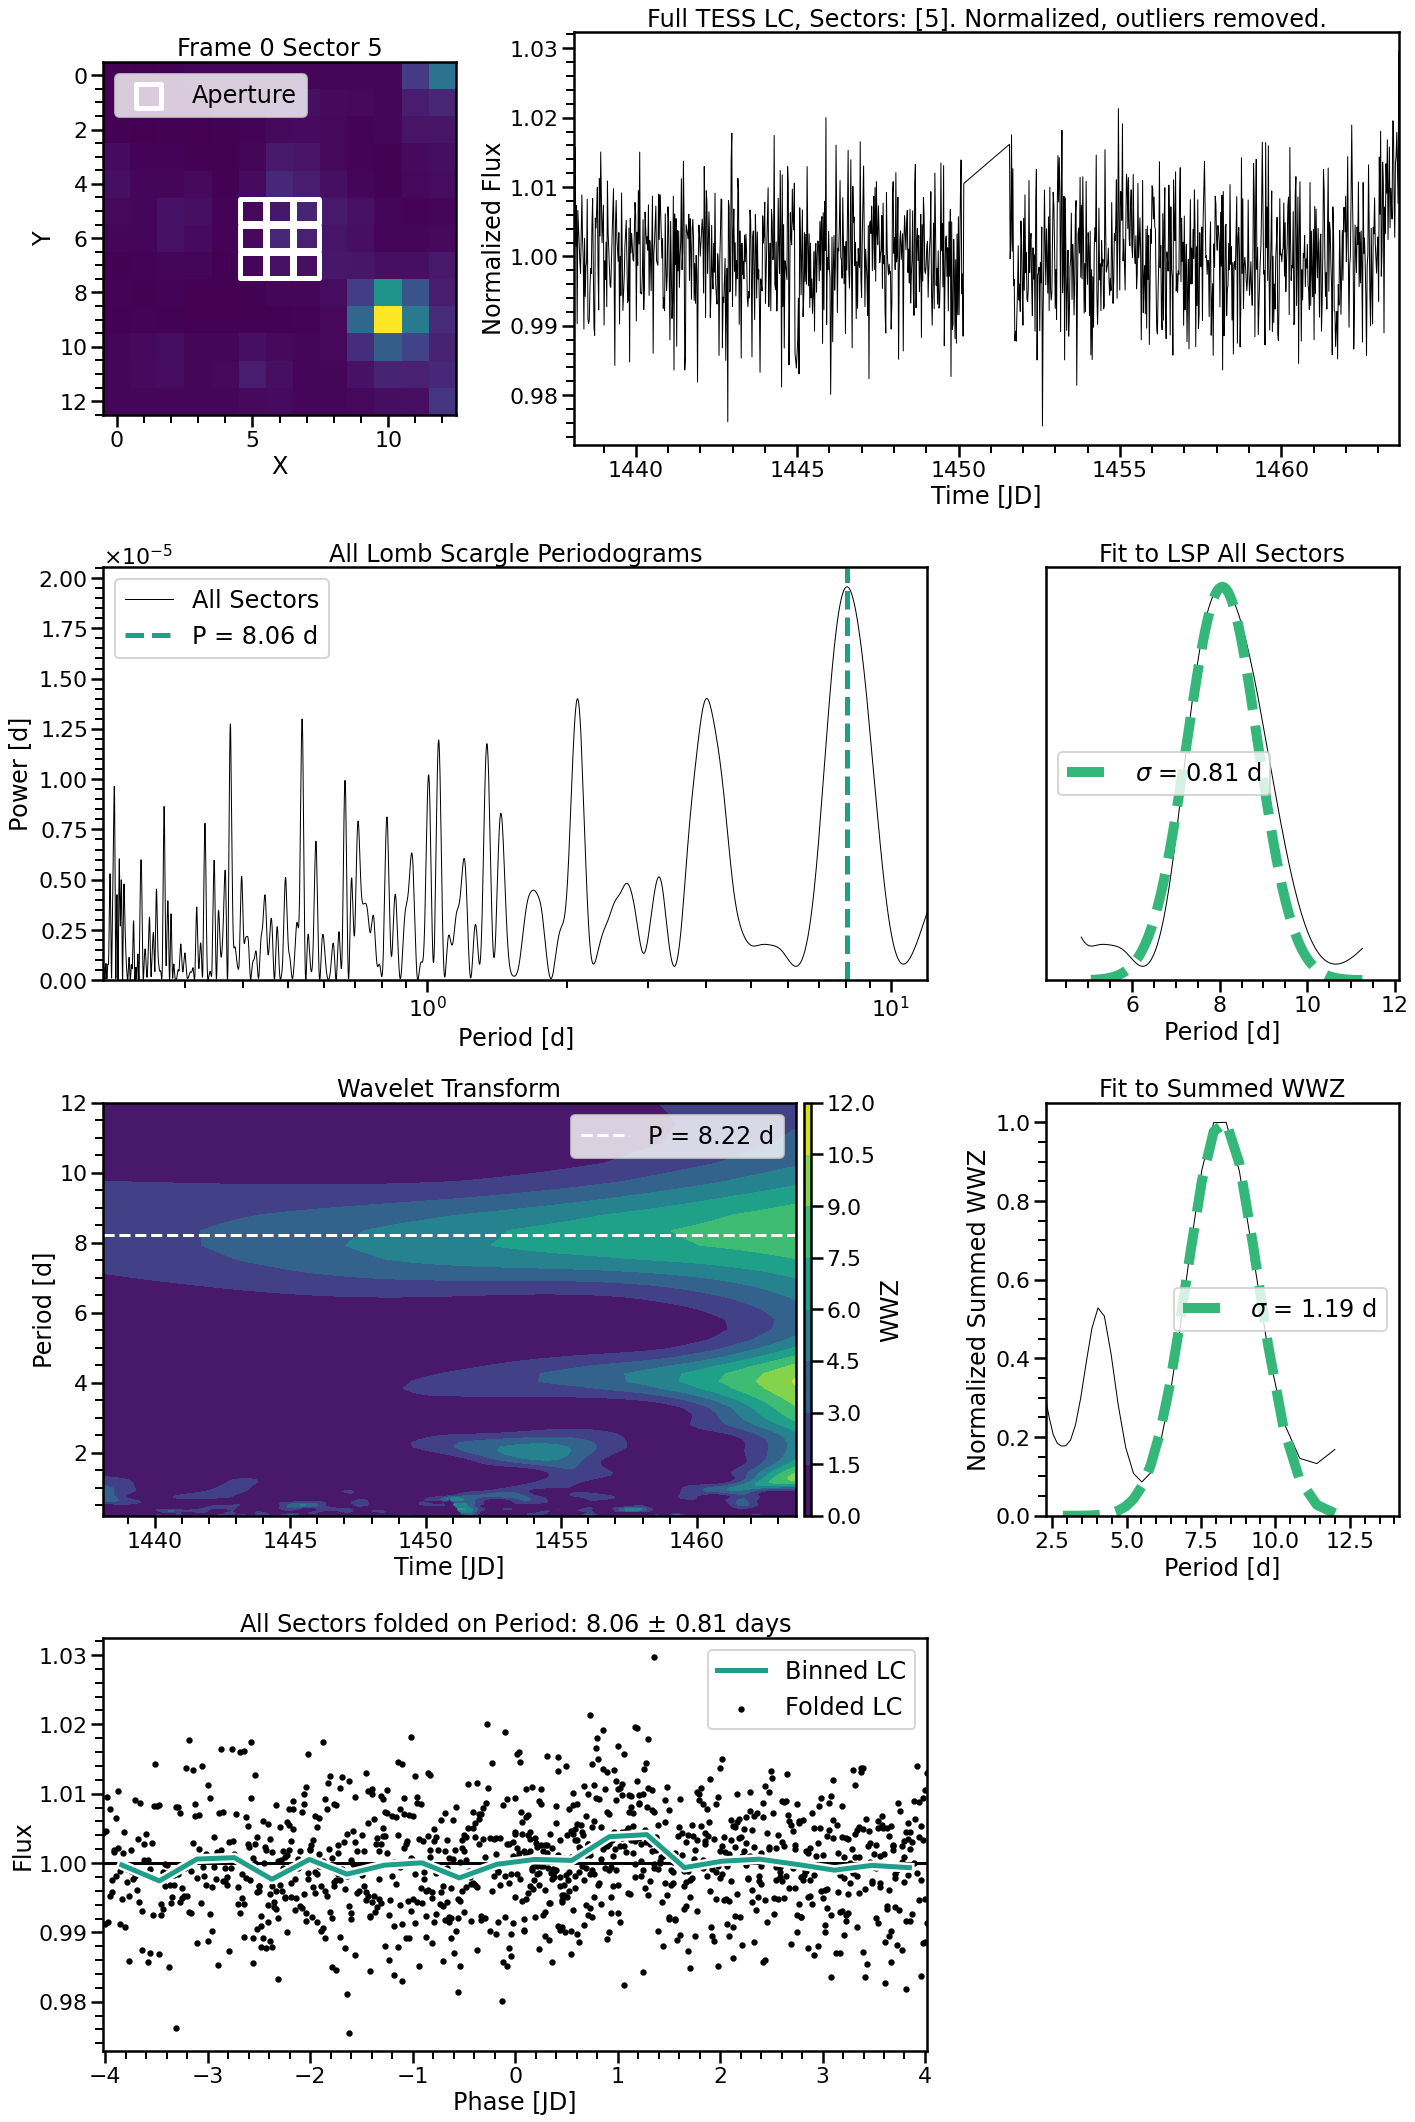

In [8]:
j.view()

In [9]:
j.results

,SLS,e_SLS,f_SLS,SW,e_SW,s_SLS,overall,e_overall,f_overall
all,8.061222,0.806122,0.0,8.21839,1.185797,NaN,NaN,NaN,NaN
best,8.061222,0.806122,NaN,8.21839,1.185797,all,8.061222,0.806122,1.0


- Improve period labels
- Add comparison plot at end
- Pickle the void